[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.2398 - val_loss: 0.0644
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0252 - val_loss: 0.0252
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0144 - val_loss: 0.0057
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0073 - val_loss: 0.0039
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0022 - val_loss: 0.0036
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


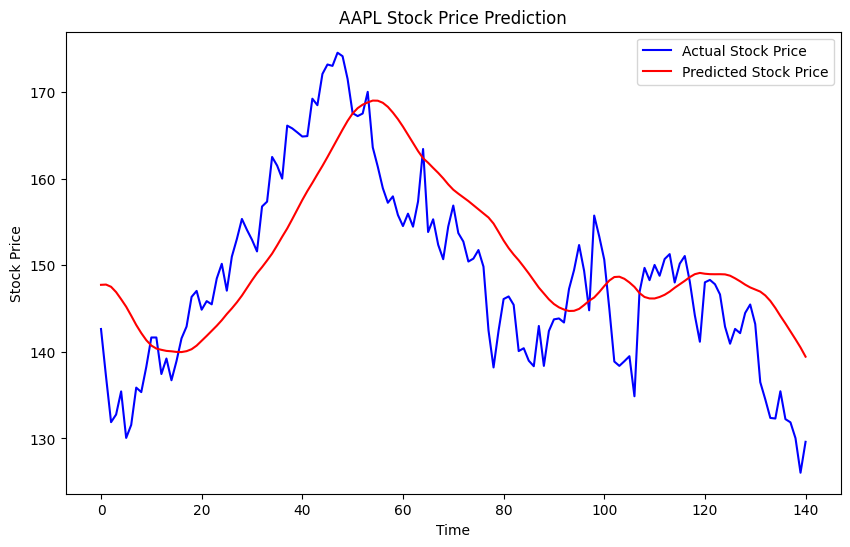

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicted next price after 2023-01-01 (for 2023-01-03): 137.5306854248047
Actual price on 2023-01-03: 125.06999969482422


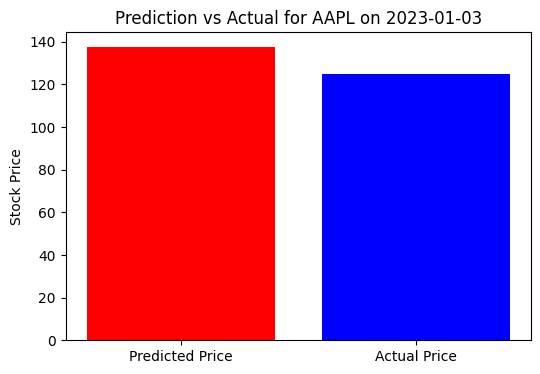

In [1]:
# Install necessary libraries (if not already installed)
!pip install yfinance --upgrade --no-cache-dir
!pip install tensorflow

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from datetime import datetime, timedelta

# Explanation of how the model predicts the next stock price:

# 1. The variable 'time_step' defines how many previous stock prices are used as input to predict the next price.
#    In this case, if time_step = 50, the model looks at the previous 50 days'
#    stock prices to predict the stock price for the next day.

# 2. The 'create_dataset()' function generates two sets of data:
#    - 'dataX': This contains sequences of 'time_step' number of stock prices.
#      For example, if time_step = 50, each entry in 'dataX' will be a sequence of 50 consecutive stock prices.
#    - 'dataY': This contains the stock price that comes immediately after each corresponding sequence
#      in 'dataX'. In other words, 'dataY' is the next day's stock price following each sequence in 'dataX'.

# 3. During training, the model learns patterns from these sequences of stock prices (dataX)
#    and tries to minimize the error between its predictions and the actual next price (dataY).

# 4. When predicting a future price, the model uses the most recent 'time_step'
#    number of prices (i.e., the last 50 stock prices) to forecast the next price.

# 5. In this specific example, the model is trained on historical data up until 2023-01-01.
#    To predict the stock price for 2023-01-03, the model uses the last 50 stock prices leading up to 2023-01-01 as input.

# This approach is a common technique in time series forecasting,
#    where the past values of the series are used to make predictions about future values.


# Download stock data (e.g., for Apple Inc)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# Prepare the data (using closing price)
prices = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Function to create dataX and dataY
def create_dataset(dataset, time_step=50):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # Sequence of n previous prices
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Next price
    return np.array(dataX), np.array(dataY)

# Create the dataset
time_step = 50
X, y = create_dataset(scaled_prices, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the neural network model (LSTM-based)
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

# Predicting stock prices
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions and actual data
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(test_predict, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# --- Prediction for 2023-01-03 ---

# Fetch actual data for 2023-01-03
future_data = yf.download(ticker, start='2023-01-03', end='2023-01-04')
actual_future_price = future_data['Close'].values.reshape(-1, 1)

# Take the last sequence of prices from the dataset to predict the next price
last_sequence = scaled_prices[-time_step:].reshape(1, time_step, 1)

# Predict the next price (for 2023-01-03)
predicted_price_scaled = model.predict(last_sequence)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Print the predicted and actual price
print(f"Predicted next price after 2023-01-01 (for 2023-01-03): {predicted_price[0][0]}")
print(f"Actual price on 2023-01-03: {actual_future_price[0][0]}")

# Compare predicted and actual prices
plt.figure(figsize=(6, 4))
plt.bar(['Predicted Price', 'Actual Price'], [predicted_price[0][0], actual_future_price[0][0]], color=['red', 'blue'])
plt.title(f'Prediction vs Actual for {ticker} on 2023-01-03')
plt.ylabel('Stock Price')
plt.show()
